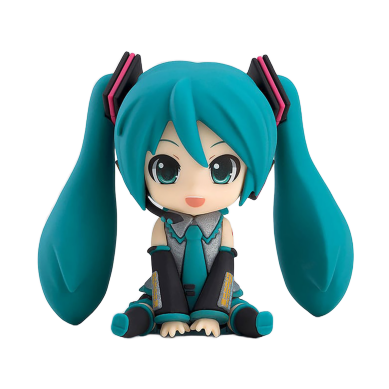

(2560, 2560, 4)

In [78]:
from PIL import Image
from skimage import io
import matplotlib.pyplot as plt
import torch
from bg_detection import BackgroundRemoval
import kornia

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

remover = BackgroundRemoval().to(device)

image_path = "image.png"
orig_im = io.imread(image_path)

rgba_batch = remover(orig_im, device=device)
rgba = rgba_batch[0].permute(1, 2, 0).cpu().numpy()  # (H,W,4)

plt.imshow(rgba)
plt.axis("off")
plt.show()

rgba.shape

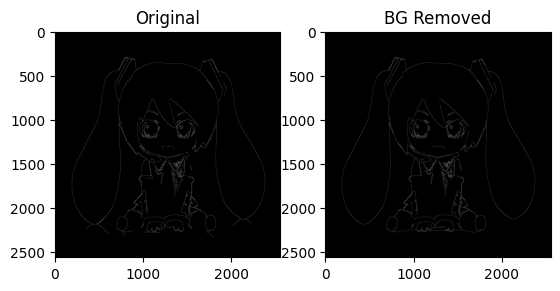

In [79]:
canny = kornia.filters.Canny(low_threshold=0.3, high_threshold=0.7)

# On original
orig_rgb = torch.tensor(orig_im, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0) / 255.0
orig_rgb = kornia.filters.bilateral_blur(orig_rgb, kernel_size=(7, 7), sigma_color=0.1, sigma_space=(1.5, 1.5))
x_magnitude, x_canny = canny(orig_rgb)

# On background-removed
alpha = rgba_batch[:, 3:].float() / 255.0
rgb = rgba_batch[:, :3].float() / 255.0
rgb = rgb * alpha + (1 - alpha)
x_mag_bg, x_canny_bg = canny(rgb)

# Compare side by side
fig, axes = plt.subplots(1, 2)
axes[0].imshow(x_canny[0, 0].cpu(), cmap='gray')
axes[0].set_title('Original')
axes[1].imshow(x_canny_bg[0, 0].cpu(), cmap='gray')
axes[1].set_title('BG Removed')
plt.show()

In [80]:
'''
import kornia
import matplotlib.pyplot as plt
import torch

# read the image with Kornia

img_tensor = kornia.io.load_image("tests/horse.png", kornia.io.ImageLoadType.RGB32)[None, ...]  # BxCxHxW
img_tensor = orig_rgb
img_array = kornia.tensor_to_image(img_tensor)


plt.axis("off")
plt.imshow(img_array)
plt.show()

img_tensor.shape
'''

'\nimport kornia\nimport matplotlib.pyplot as plt\nimport torch\n\n# read the image with Kornia\n\nimg_tensor = kornia.io.load_image("tests/horse.png", kornia.io.ImageLoadType.RGB32)[None, ...]  # BxCxHxW\nimg_tensor = orig_rgb\nimg_array = kornia.tensor_to_image(img_tensor)\n\n\nplt.axis("off")\nplt.imshow(img_array)\nplt.show()\n\nimg_tensor.shape\n'

In [81]:
'''
canny = kornia.filters.Canny()
alpha = rgba_batch[:, 3:] / 255.0
rgb = (rgba_batch[:, :3] * alpha + 255 * (1 - alpha))
x_magnitude, x_canny = canny(orig_rgb)
'''

'\ncanny = kornia.filters.Canny()\nalpha = rgba_batch[:, 3:] / 255.0\nrgb = (rgba_batch[:, :3] * alpha + 255 * (1 - alpha))\nx_magnitude, x_canny = canny(orig_rgb)\n'

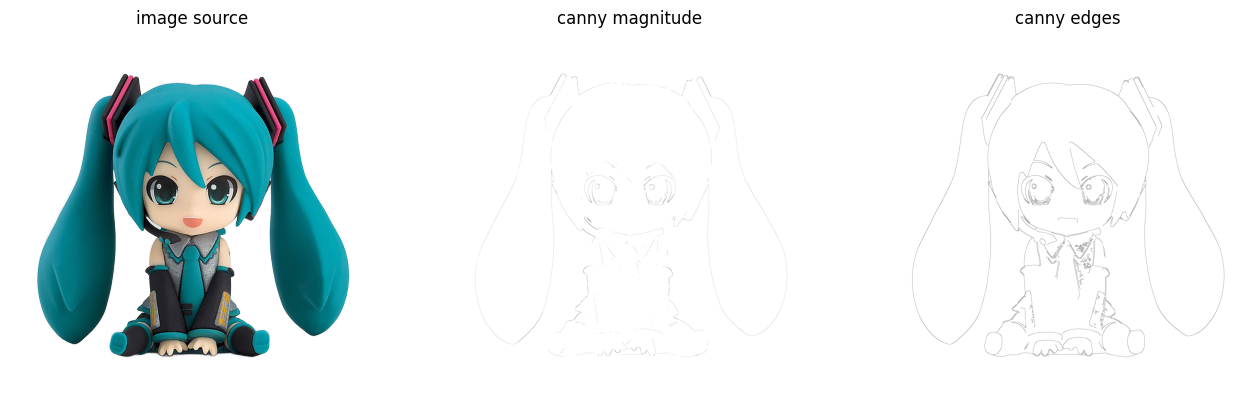

In [82]:
img_magnitude = kornia.tensor_to_image(x_mag_bg.byte())
img_canny = kornia.tensor_to_image(x_canny_bg.byte())

# Create the plot
fig, axs = plt.subplots(1, 3, figsize=(16, 16))
axs = axs.ravel()

axs[0].axis("off")
axs[0].set_title("image source")
axs[0].imshow(rgba)

axs[1].axis("off")
axs[1].set_title("canny magnitude")
axs[1].imshow(img_magnitude, cmap="Greys")

axs[2].axis("off")
axs[2].set_title("canny edges")
axs[2].imshow(img_canny, cmap="Greys")

plt.show()

In [83]:
# create the operator
canny = kornia.filters.Canny(low_threshold=0.3, high_threshold=0.7)
from kornia.filters import gaussian_blur2d


# blur the image
#_, x_canny_threshold = canny(gaussian_blur2d(rgb, kernel_size=(9, 9), sigma=(1.5, 1.5)))

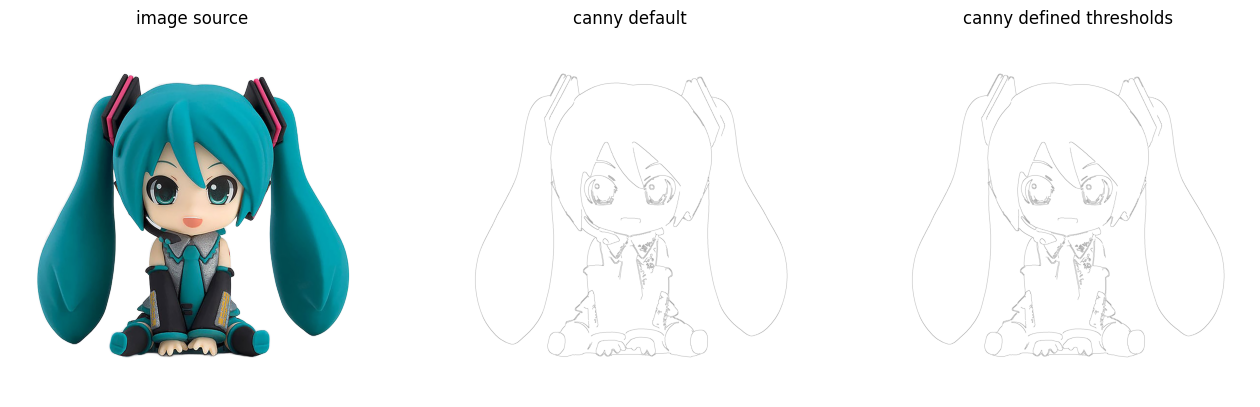

In [84]:
import torch.nn.functional as F

# convert back to numpy
img_canny_threshold = kornia.tensor_to_image(x_canny_bg.byte())

# Create the plot
fig, axs = plt.subplots(1, 3, figsize=(16, 16))
axs = axs.ravel()

axs[0].axis("off")
axs[0].set_title("image source")
axs[0].imshow(rgba)

axs[1].axis("off")
axs[1].set_title("canny default")
axs[1].imshow(img_canny, cmap="Greys")

axs[2].axis("off")
axs[2].set_title("canny defined thresholds")
axs[2].imshow(img_canny_threshold, cmap="Greys")

plt.show()

In [85]:
from torch import nn

input = torch.randn(2, 3, 256, 256)

kernel_size = (32, 32)
stride = 32
padding = 0

unfold = nn.Unfold(kernel_size=kernel_size, stride=stride, padding=padding)
output = unfold(input)


output.shape

torch.Size([2, 3072, 64])

In [86]:
import string
from PIL import Image, ImageDraw, ImageFont

CHARS = string.ascii_letters + string.digits + string.punctuation + " "
#CHARS = " -_|/\\+LJr7()Cc#@"

FONT_PATH = "src/ascii_nn/data/RobotoMono-VariableFont_wght.ttf"
FONT_SIZE = 32
PAD = 0
RATIO = 2.5

font = ImageFont.truetype(FONT_PATH, FONT_SIZE)

H = FONT_SIZE + PAD
W = int((FONT_SIZE + PAD) / RATIO + 0.5)

def char2img(c):
    img = Image.new("L", (W, H), 0)
    draw = ImageDraw.Draw(img)

    # Measure bbox at origin
    left, top, right, bottom = draw.textbbox((0, 0), c, font=font)
    text_w, text_h = right - left, bottom - top

    # Center the glyph box
    x = (W - text_w) // 2
    y = (H - text_h) // 2

    # Shift by -left, -top so glyph is drawn correctly relative to bbox
    draw.text((x - left, y - top), c, fill=255, font=font)

    return img

(H, W)

(32, 13)

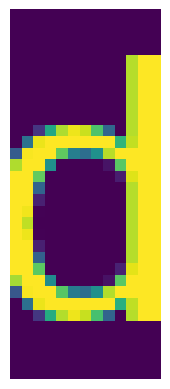

In [94]:
img = char2img("d")

plt.axis("off")
plt.imshow(img)
plt.show()

In [88]:
import torch
from torchvision.transforms import ToTensor

print(CHARS, len(CHARS))

to_tensor = ToTensor()

chars = []
for c in CHARS:
  img = char2img(c)
  chars.append(to_tensor(img))


chars = torch.stack(chars)
chars.shape



abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~  95


torch.Size([95, 1, 32, 13])

torch.Size([1, 1, 2560, 2560])


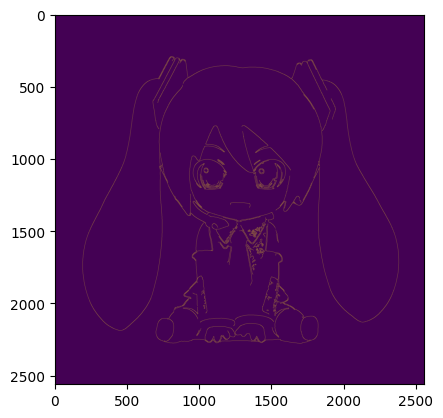

In [89]:
from torch import nn

img_tensor = kornia.io.load_image("tests/horse.png", kornia.io.ImageLoadType.GRAY32)[None, ...]  # BxCxHxW
#img_tensor = F.interpolate(x_canny_bg, scale_factor=4, mode='bilinear', align_corners=False)
img_tensor = x_canny_bg
kernel_size = (H, W)
stride = kernel_size
padding = 0

unfold = nn.Unfold(kernel_size=kernel_size, stride=stride, padding=padding)
output = unfold(input)

print(img_tensor.shape)
plt.imshow(kornia.tensor_to_image(img_tensor))
plt.show()

In [90]:
horse = unfold(img_tensor).squeeze(0).T.view(-1, 1, H, W)
horse.shape

torch.Size([15680, 1, 32, 13])

In [91]:
string = ""
for i in range(len(horse)):
  scores = kornia.metrics.ssim(horse[i].expand(len(chars), -1, -1, -1), chars, 9).mean(dim=(1, 2, 3))
  best_score = scores.max()
  best_idx = scores.argmax()

  if best_score > 0.035:
    string += CHARS[best_idx]
  else:
    string += " "
  
  if (i + 1) % (img_tensor.shape[-1] // W) == 0:
    string += "\n"

print(string)


In [92]:
num_tiles = len(horse)
num_refs = len(chars)
all_scores = torch.zeros(num_tiles, num_refs)

horse = horse.to('mps')
chars = chars.to('mps')

# Process in chunks to avoid OOM
chunk_size = 128
for i in range(0, num_tiles, chunk_size):
    chunk = horse[i:i+chunk_size]  # (chunk_size, 1, H, W)
    cs = chunk.shape[0]
    
    # Expand for broadcasting
    chunk_exp = chunk[:, None].expand(-1, num_refs, -1, -1, -1).reshape(-1, 1, H, W)
    refs_exp = chars[None].expand(cs, -1, -1, -1, -1).reshape(-1, 1, H, W)
    
    scores = kornia.metrics.ssim(chunk_exp, refs_exp, 9).mean(dim=(1, 2, 3))
    all_scores[i:i+cs] = scores.view(cs, num_refs)

# Now build your string
best_scores, best_indices = all_scores.max(dim=1)
num_cols = img_tensor.shape[-1] // W

string = ""
for i in range(num_tiles):
    if best_scores[i] > 0.05:
        string += CHARS[best_indices[i]]
    else:
        string += " "
    if (i + 1) % num_cols == 0:
        string += "\n"

print(string)

In [93]:
horse = horse.to('mps')
chars = chars.to('mps')

tile_means = horse.mean(dim=(1, 2, 3))
char_means = chars.mean(dim=(1, 2, 3))

diffs = (tile_means[:, None] - char_means[None, :]).abs()
best_indices = diffs.argmin(dim=1)

num_cols = img_tensor.shape[-1] // W

string = ""
for i in range(len(horse)):
    string += CHARS[best_indices[i]]
    if (i + 1) % num_cols == 0:
        string += "\n"

print(string)